![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Importación librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

### Análisis exploratorio de datos

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [6]:
nulos = dataTraining.isnull().sum()               # Busqueda de valores nulos
duplicados = dataTraining.duplicated().sum()      # Busqueda de valores repetidos
titulos_unicos = dataTraining['title'].nunique()  # títulos únicos de películas

print(f'Valores nulos:\n{nulos}')
print(f'\nValores duplicados: {duplicados}')
print(f'\nCantidad de títulos únicos: {titulos_unicos}')

Valores nulos:
year      0
title     0
plot      0
genres    0
rating    0
dtype: int64

Valores duplicados: 1

Cantidad de títulos únicos: 7729


In [7]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [8]:
# Listado de películas con títulos duplicados
dataTraining[dataTraining.duplicated(subset=['title'], keep=False)].sort_values('title')

,year,title,plot,genres,rating
10885,1916,"20,000 Leagues Under the Sea",captain nemo has built a fantastic submarine f...,"['Action', 'Adventure', 'Sci-Fi']",7.1
10745,1954,"20,000 Leagues Under the Sea","in N , a monster is terrorizing the seas , ...","['Adventure', 'Drama', 'Family', 'Fantasy', 'S...",7.2
9182,1957,3:10 to Yuma,when the charming outlaw ben wade is captured ...,"['Drama', 'Thriller', 'Western']",7.6
2583,2007,3:10 to Yuma,rancher dan evans heads into bisbee to clear u...,"['Adventure', 'Crime', 'Drama', 'Western']",7.8
8062,1938,A Christmas Carol,"in the nineteenth century , in london , the ...","['Drama', 'Family', 'Fantasy']",7.5
...,...,...,...,...,...
8107,1959,Warlock,the town of warlock is plagued by a gang of th...,"['Romance', 'Western']",7.3
4314,2000,Where the Heart Is,"having lived her entire life in a trailer , n...","['Comedy', 'Drama', 'Romance']",6.8
9969,1990,Where the Heart Is,stewart mcbain ( coleman ) is a real - estat...,"['Comedy', 'Drama']",6.2
508,1939,Wuthering Heights,the story of unfortunate lovers heathcliff and...,"['Drama', 'Romance']",7.7


#### Librerias

In [9]:
import ast
from itertools import chain
from collections import Counter

In [10]:
dataTraining['genres_list'] = dataTraining['genres'].apply(ast.literal_eval)

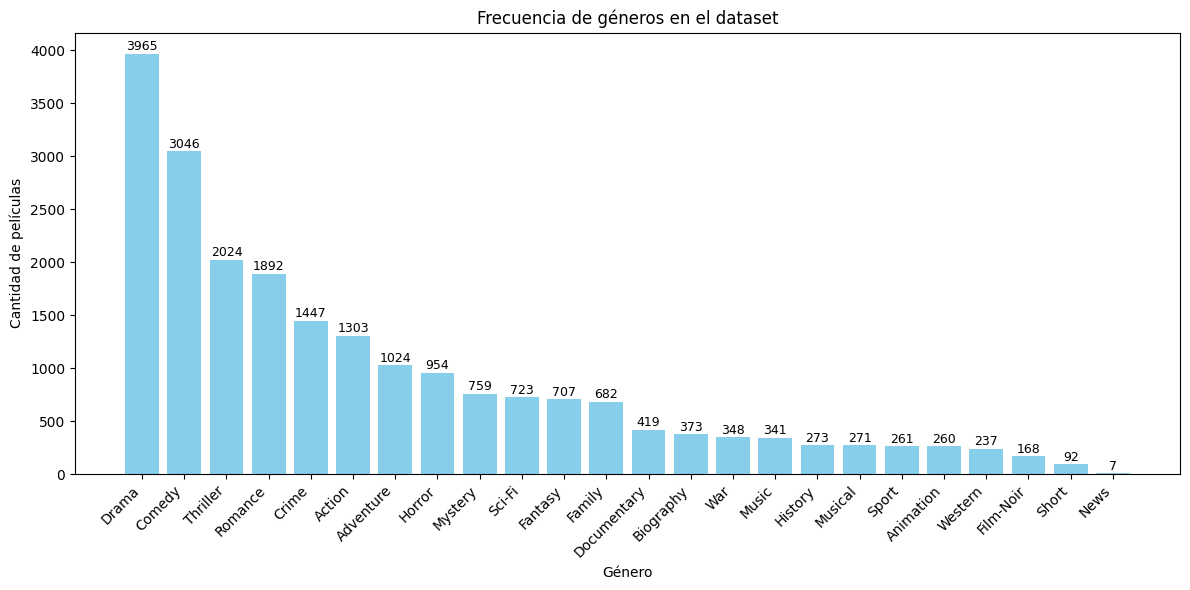

In [11]:
frecuencia_generos = list(chain.from_iterable(dataTraining['genres_list']))

conteo_generos = Counter(frecuencia_generos)

sorted_genres = conteo_generos.most_common()
genres, counts = zip(*sorted_genres)

plt.figure(figsize=(12, 6))
bars = plt.bar(genres, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.title('Frecuencia de géneros en el dataset')
plt.tight_layout()

# Paso 5: Añadir etiquetas a cada barra
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=9)

plt.show()

# Primer Modelo

Simple nltk y WordNetLemmatizer

In [12]:
# Primer modelo
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [13]:
# Descarga de recursos de NLTK
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.word_tokenize("example")
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

In [14]:
# Inicialización de herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
# Función de preprocesamiento
def preprocess_text_1(text):
    if isinstance(text, str): # Asegurarse de que la entrada sea una cadena
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text) # Liempieza de caracteres diferentes a letras, sustitucion por " "
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2] # Lematización y eliminación de stopwords y palabras cortas
        return ' '.join(tokens)
    return '' # Manejar casos donde el texto no es una cadena

# Segundo Modelo

Spacy

In [16]:
import unicodedata
import spacy

In [17]:
# Descarga de recursos de spacy
try:
    spacy.util.is_package("en_core_web_sm")
except LookupError:
    spacy.cli.download("en_core_web_sm")

In [18]:
# Carga del modelo en inglés (puede ser 'en_core_web_md' para embeddings si se desea)
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # Solo necesitamos tokenizer y tagger

In [19]:
# Lista personalizada de POS que aportan valor semántico
valid_pos = {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}  # Incluye nombres propios útiles para géneros

In [20]:
def preprocess_text_spacy(text):
    if not isinstance(text, str):
        return ''
    
    # Normalización unicode y minúsculas
    text = unicodedata.normalize("NFKD", text)
    text = text.lower()
    
    # Eliminar caracteres no alfabéticos (mantener espacios)
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Procesar con spaCy
    doc = nlp(text)

    # Filtrar tokens útiles: sin stopwords, con longitud >2, con POS válida
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and len(token) > 2 and token.pos_ in valid_pos
    ]
    
    return ' '.join(tokens)

# Tercer Modelo

BERT

In [21]:
from transformers import BertTokenizer, BertModel
import torch

# Modelo preentrenado base (hay más como DistilBERT si quieres mayor velocidad)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [22]:
def get_bert_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Promediar sobre la dimensión de secuencia (tokens)
        embedding = last_hidden_state.mean(dim=1)  # [batch_size, hidden_size]
        return embedding.squeeze().numpy()  # [hidden_size]


# Resultados del preprocesamiento

In [23]:
from tqdm import tqdm
tqdm.pandas()

In [24]:
# Aplicar a los datos
dataTraining['plot_clean_1'] = dataTraining['plot'].apply(preprocess_text_1)
dataTesting['plot_clean_1'] = dataTesting['plot'].apply(preprocess_text_1)

dataTraining['plot_clean_spacy'] = dataTraining['plot'].apply(preprocess_text_spacy)
dataTesting['plot_clean_spacy'] = dataTesting['plot'].apply(preprocess_text_spacy)

dataTraining['plot_clean_bert'] = dataTraining['plot'].apply(get_bert_embedding)
dataTesting['plot_clean_bert'] = dataTesting['plot'].apply(get_bert_embedding)

In [25]:
dataTraining.head()

,year,title,plot,genres,rating,genres_list,plot_clean_1,plot_clean_spacy,plot_clean_bert
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,"[Short, Drama]",story single father take eight year old son wo...,story single father take year old son work rai...,"[-0.22755995, -0.03309984, 0.1763552, -0.08189..."
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,"[Comedy, Crime, Horror]",serial killer decides teach secret satisfying ...,serial killer decide teach secret satisfy care...,"[0.576089, -0.09917219, 0.25265494, -0.0780117..."
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,"[Drama, Film-Noir, Thriller]",sweden female blackmailer disfiguring facial s...,sweden female blackmailer disfigure facial sca...,"[-0.2900472, -0.09339563, 0.50916076, -0.23077..."
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,[Drama],friday afternoon new york president tredway co...,friday afternoon new york president tredway co...,"[-0.31722695, -0.14288686, 0.33394265, 0.06100..."
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,"[Action, Crime, Thriller]",los angeles editor publishing house carol hunn...,los angeles editor publishing house carol hunn...,"[-0.30751452, -0.039901253, 0.24443263, -0.025..."


In [26]:
vect = CountVectorizer(max_features=1000)
X_dtm_1 = vect.fit_transform(dataTraining['plot_clean_1'])
X_dtm_1.shape

X_dtm_spacy = vect.fit_transform(dataTraining['plot_clean_spacy'])
X_dtm_spacy.shape

X_bert = np.vstack(dataTraining['plot_clean_bert'].values)

### Multiclasificacion

In [ ]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(dataTraining['genres_list'])

genre_labels = mlb.classes_

# Crear nuevo DataFrame con columnas binarias
genre_df = pd.DataFrame(genre_matrix, columns=genre_labels)

# Unir al dataframe original si lo deseas
dataTraining_bin = pd.concat([dataTraining.reset_index(drop=True), genre_df], axis=1)
dataTraining_bin.head()

## Entrenamiento del modelo

In [28]:
# Codificación de etiquetas de salida (géneros)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))  # convertir a lista
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

# Primer Modelo

In [49]:
# División en entrenamiento y prueba
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm_1, y_genres, test_size=0.33, random_state=42)

In [50]:
# Clasificador con Random Forest y One-vs-Rest
clf = OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))

In [51]:
# Predicción
y_pred_genres = clf.predict_proba(X_test)

# Evaluación
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8074515158472976

In [52]:
X_test_dtm_1 = vect.fit_transform(dataTesting['plot_clean_1'])
y_pred_test_genres_1 = clf.predict_proba(X_test_dtm_1)

# Segundo Modelo

In [53]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm_spacy, y_genres, test_size=0.33, random_state=42)

In [54]:
# Definición y entrenamiento
clf = OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))

In [55]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8086966532780245

In [56]:
X_test_dtm_spacy = vect.fit_transform(dataTesting['plot_clean_spacy'])
y_pred_test_genres_spacy = clf.predict_proba(X_test_dtm_spacy)

# Tercer Modelo

In [57]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_bert, y_genres, test_size=0.33, random_state=42)

In [58]:
# Definición y entrenamiento
clf = OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))

In [59]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.9115145990868244

In [60]:
X_test_bert = np.vstack(dataTesting['plot_clean_bert'].values)
y_pred_test_genres_bert = clf.predict_proba(X_test_bert)

## Aplicación del modelo a datos de test

In [61]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres_spacy, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF_spacy_A.csv', index_label='ID')
res.head()

In [62]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres_bert, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_LR_bert_A.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.003196,0.001413,0.006395,0.001439,0.049484,0.022421,0.000423,0.817498,0.009239,0.039474,...,0.015295,0.329368,0.000136,0.974037,0.001934,0.005550,0.000214,0.190405,0.000252,0.002998
4,0.179638,0.022834,0.000150,0.119100,0.143550,0.609876,0.207107,0.928563,0.000153,0.000024,...,0.000348,0.002900,0.000402,0.071821,0.000091,0.000051,0.000637,0.165569,0.002066,0.000008
5,0.032053,0.007276,0.001411,0.104132,0.068534,0.802945,0.003077,0.870831,0.001932,0.004625,...,0.000468,0.180392,0.000426,0.061551,0.008827,0.000079,0.002670,0.760115,0.005598,0.002290
6,0.235152,0.203288,0.002252,0.003103,0.164983,0.026943,0.000125,0.509052,0.002766,0.035160,...,0.006613,0.012855,0.000178,0.295916,0.027548,0.000461,0.005552,0.389987,0.170289,0.001271
7,0.004966,0.005756,0.000976,0.006922,0.101593,0.081031,0.000603,0.157072,0.012699,0.020646,...,0.008327,0.144826,0.000044,0.212897,0.701168,0.004158,0.000890,0.384560,0.000784,0.000142
